# Objective

### The goal of this project is to predict the next day’s closing stock price based on the past 60 days of historical stock market data.

### We use a Long Short-Term Memory (LSTM) neural network, which is specifically designed for time-series forecasting.

# Imports

In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import pickle


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data Reading

In [36]:
df = pd.read_excel("Yahoo_stock_data.xlsx")
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-03-04,73.468651,73.628820,71.136509,71.939776,219178400
1,2020-03-05,71.085548,72.694504,70.719101,71.716508,187572800
2,2020-03-06,70.141487,70.575884,68.248595,68.435455,226176800
3,2020-03-09,64.593903,67.486633,63.824607,64.006616,286744800
4,2020-03-10,69.246033,69.512981,65.370448,67.256069,285290000


# Data Preparation and EDA

### To begin, we import essential libraries such as NumPy, Pandas, Matplotlib, and Seaborn for data handling and visualization. We use Yahoo Finance to fetch historical stock data. The dataset includes daily stock prices, and we analyze trends by plotting the closing price over time. Basic Exploratory Data Analysis (EDA) helps identify missing values and general price movement patterns.

In [37]:
df.describe()

,Date,Close,High,Low,Open,Volume
count,1256,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03
mean,2022-08-30 05:38:12.993630464,157.429534,159.017700,155.661331,157.275070,8.713139e+07
min,2020-03-04 00:00:00,54.449886,55.452152,51.595983,55.350227,2.323470e+07
25%,2021-06-01 18:00:00,130.590229,131.919717,128.955912,130.634571,5.392302e+07
50%,2022-08-29 12:00:00,154.884712,156.823950,152.105368,154.564538,7.408865e+07
75%,2023-11-28 06:00:00,181.581795,183.081801,179.925048,181.264824,1.024327e+08
max,2025-03-03 00:00:00,258.735504,259.814335,257.347047,257.906429,4.184740e+08
std,NaN,42.130022,42.291982,41.878111,42.070240,5.051586e+07


In [38]:
# Check for missing values
df.isnull().sum()


### No Missing values present

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

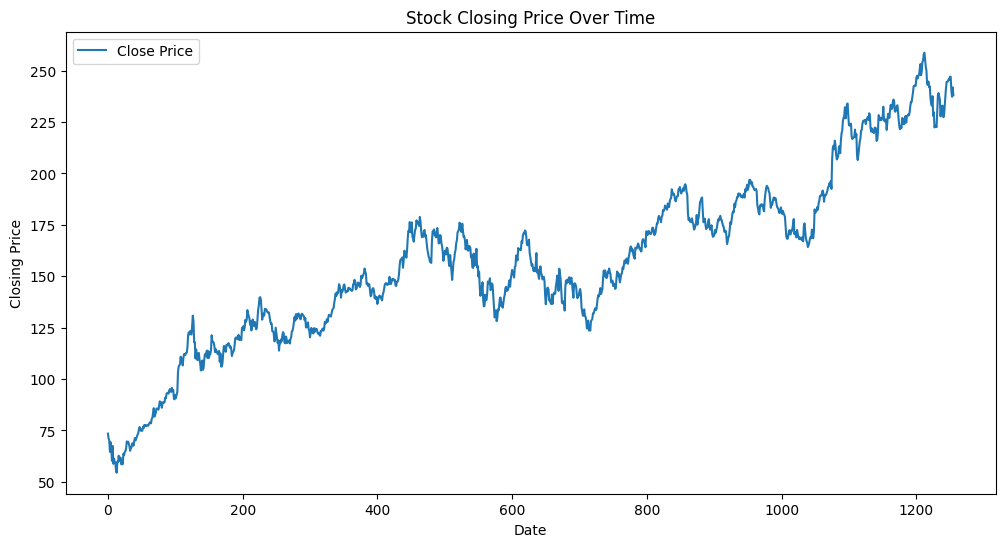

In [39]:
## checking close price treds and patterns
# Plot Closing Price over time
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label="Close Price")
plt.title(f"Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

# Feature Selection

### Next, we perform feature selection by choosing the most relevant attributes: Open, High, Low, Close, and Volume. Since stock prices fluctuate in large numerical ranges, we apply MinMax Scaling, which normalizes the values between 0 and 1, ensuring better model convergence. To prepare the data for LSTM, we create sequential input-output pairs, where the model learns patterns from the last 60 days of data to predict the next day’s closing price. The data is reshaped into the format required for LSTM

In [40]:
# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
df = df[features]

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
df_scaled

array([[0.08190097, 0.0889434 , 0.09497169, 0.09309889, 0.49575966],
       [0.08079872, 0.08437154, 0.09294299, 0.08143335, 0.41579393],
       [0.06460048, 0.07400456, 0.08093573, 0.07681207, 0.5134664 ],
       ...,
       [0.90868497, 0.91508053, 0.90140003, 0.89507092, 0.04533684],
       [0.89654016, 0.91326997, 0.86805876, 0.91729468, 0.0850085 ],
       [0.92043474, 0.92276293, 0.89678281, 0.89864433, 0.06035204]])

### It takes the past 60 days of stock market data as input to predict the next day's closing price. The loop iterates through the dataset, extracting rolling windows of 60 day sequences as features and storing the closing price of the next day as the target. This format is essential for training deep learning models like LSTMs, which require sequential input to learn patterns in historical stock prices.

In [41]:
# Define sequence length (past 60 days of data to predict next day)
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i])  
    y.append(df_scaled[i, 3])  



In [42]:
# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X for LSTM model
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Print dataset shapes
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")


Shape of X: (1196, 60, 5), Shape of y: (1196,)


# Model Building

### The LSTM model consists of two LSTM layers to extract sequential dependencies in stock prices. We include dropout layers (20%) to prevent overfitting and fully connected dense layers for final price prediction. The model is compiled using the Adam optimizer and Mean Squared Error (MSE) as the loss function, which is suitable for regression problems. We train the model using 10 epochs with a batch size of 20, splitting the dataset into 90% training and 10% validation data because we have less data.

In [43]:
# Define the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)  # Predict next day's close price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Train the model
his_model = model.fit(X, y, epochs=10, batch_size=20, validation_split=0.1)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.1064 - val_loss: 0.0166
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0021 - val_loss: 0.0014


## Save Model

In [45]:
# Save the model
with open("models/lstm_model.pkl", "wb") as file:
    pickle.dump(model, file)



# Prediction 

### For prediction, we extract the last 60 days of stock prices from the dataset, reshape it into the required format, and pass it through the trained model. The output is a scaled closing price, which we convert back to the original price range using inverse transformation. Finally, we evaluate the model by plotting training vs. validation loss to check for overfitting and visualize how well the predicted closing prices align with actual prices.

In [46]:
# Load the model
with open("models/lstm_model.pkl", "rb") as file:
    model = pickle.load(file)

In [47]:
# Extract last 60 days of stock data
last_60_days = df_scaled[-sequence_length:]
X_test = np.array([last_60_days])
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Predict the next day's closing price
predicted_price = model.predict(X_test)

# Convert prediction back to original scale
predicted_price = scaler.inverse_transform(
    np.hstack((np.zeros((1, 3)), predicted_price, np.zeros((1, 1))))
)[0, 3]  # Extract Close price after inverse transformation

print(f"📈 Predicted Closing Price for Next Day: ${predicted_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
📈 Predicted Closing Price for Next Day: $239.76


# plot model loss

### We plot the loss curves, where the training loss represents the model's error on the training dataset, and the validation loss helps determine whether the model is overfitting. A decreasing loss indicates that the model is learning, while a significant gap between training and validation loss suggests overfitting. After evaluating the loss, we predict stock prices using the trained model on the same dataset it was trained on. Since the model was trained on scaled data, we need to inverse transform the predictions to convert them back to the original stock price range. We use the MinMaxScaler to revert both the actual closing prices and the predicted prices to their original values. Finally, we plot both actual and predicted stock prices over time. This visualization allows us to compare how closely the predicted values follow the real stock price trends, helping to assess the model’s effectiveness in capturing market patterns.

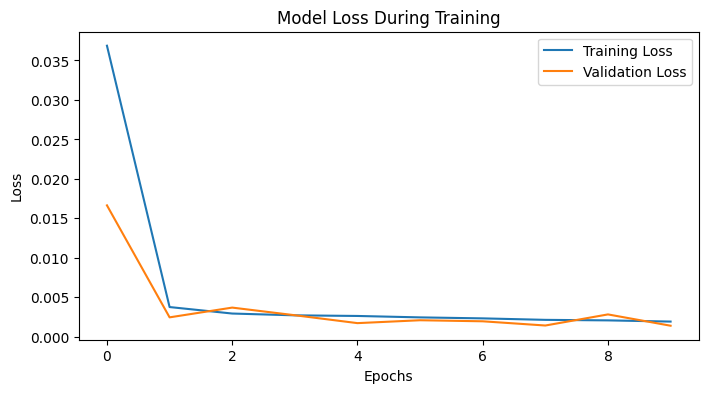

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step  


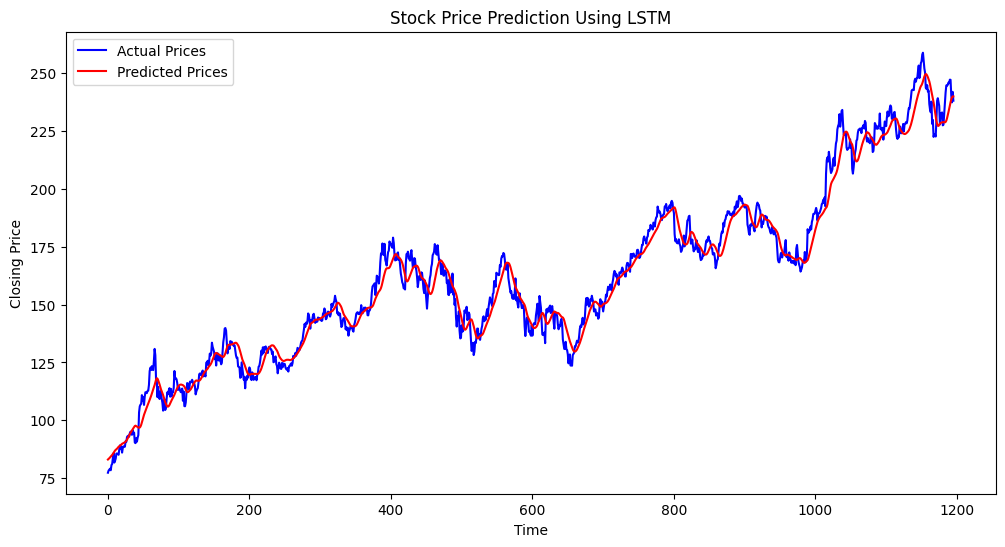

In [48]:
# Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(his_model.history['loss'], label="Training Loss")
plt.plot(his_model.history['val_loss'], label="Validation Loss")
plt.title("Model Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Predict on Training Data for visualization
train_predictions = model.predict(X)

# Convert predictions back to original scale
train_actual = scaler.inverse_transform(
    np.hstack((np.zeros((len(y), 3)), y.reshape(-1,1), np.zeros((len(y), 1))))
)[:, 3]

train_predicted = scaler.inverse_transform(
    np.hstack((np.zeros((len(y), 3)), train_predictions, np.zeros((len(y), 1))))
)[:, 3]

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12,6))
plt.plot(train_actual, label="Actual Prices", color='blue')
plt.plot(train_predicted, label="Predicted Prices", color='red')
plt.legend()
plt.title("Stock Price Prediction Using LSTM")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.show()
